# BÀI THỰC HÀNH 3: MẠNG NEURAL HỒI QUY CHO BÀI TOÁN PHÂN LOẠI VĂN BẢN VÀ GÁN NHÃN CHUỖI

Họ tên: Trần Nhật Phương Anh  
MSSV: 23520078

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses.

Bộ dữ liệu sử dụng: [UIT-VSFC](https://drive.google.com/drive/folders/1rdcXNGt_3-QUvV8EtSvVsLMVeHmk6Yqk?usp=drive_link) và [PhoNERT](https://github.com/VinAIResearch/PhoNER_COVID19).

In [49]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import math
from collections import Counter
import unicodedata
import underthesea
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# EDA DATASET

Yêu cầu: Thực hiện EDA và tiền xử lý 2 bộ dataset trước khi làm bài lab

## BỘ DỮ LIỆU UIT-VSFC (Phân loại văn bản)

1. Kiểm tra cấu trúc bộ dữ liệu

* Tải và đọc các file .txt hoặc .csv từ UIT-VSFC.

* Kiểm tra các cột có trong dataset (ví dụ: sentence, label).

* Kiểm tra số lượng mẫu train/valid/test.

* Lấy 10 mẫu đầu tiên để xem dữ liệu thực trông như thế nào.

In [2]:
# Tải và đọc các file .txt hoặc .csv từ UIT-VSFC.
with open('UIT-VSFC/UIT-VSFC-train.json', 'r', encoding = 'utf-8') as f:
    UIT_VSFC_train = json.load(f)
    
with open('UIT-VSFC/UIT-VSFC-dev.json', 'r', encoding = 'utf-8') as f:
    UIT_VSFC_dev = json.load(f)
    
with open('UIT-VSFC/UIT-VSFC-test.json', 'r', encoding = 'utf-8') as f:
    UIT_VSFC_test = json.load(f)

In [3]:
# Kiểm tra các cột có trong dataset (ví dụ: sentence, label)
print('Train: ', list(UIT_VSFC_train[0].keys()))
print('Dev: ', list(UIT_VSFC_dev[0].keys()))
print('Test: ', list(UIT_VSFC_test[0].keys()))

Train:  ['sentence', 'sentiment', 'topic']
Dev:  ['sentence', 'sentiment', 'topic']
Test:  ['sentence', 'sentiment', 'topic']


In [4]:
# Kiểm tra số lượng mẫu train/valid/test.
print('Số lượng mẫu Train: ', len(UIT_VSFC_train))
print('Số lượng mẫu Dev: ', len(UIT_VSFC_dev))
print('Số lượng mẫu Test: ', len(UIT_VSFC_test))

Số lượng mẫu Train:  11426
Số lượng mẫu Dev:  1583
Số lượng mẫu Test:  3166


In [5]:
# Lấy 10 mẫu đầu tiên để xem dữ liệu thực trông như thế nào.
print('10 mẫu đầu tiên trong tập Train:')
for sample in UIT_VSFC_train[:10]:
    print(sample)
    
print('\n10 mẫu đầu tiên trong tập Dev:')
for sample in UIT_VSFC_dev[:10]:
    print(sample)
    
print('\n10 mẫu đầu tiên trong tập Test:')
for sample in UIT_VSFC_test[:10]:
    print(sample)

10 mẫu đầu tiên trong tập Train:
{'sentence': 'slide giáo trình đầy đủ .', 'sentiment': 'positive', 'topic': 'training_program'}
{'sentence': 'nhiệt tình giảng dạy , gần gũi với sinh viên .', 'sentiment': 'positive', 'topic': 'lecturer'}
{'sentence': 'đi học đầy đủ full điểm chuyên cần .', 'sentiment': 'negative', 'topic': 'training_program'}
{'sentence': 'chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy .', 'sentiment': 'negative', 'topic': 'lecturer'}
{'sentence': 'thầy giảng bài hay , có nhiều bài tập ví dụ ngay trên lớp .', 'sentiment': 'positive', 'topic': 'lecturer'}
{'sentence': 'giảng viên đảm bảo thời gian lên lớp , tích cực trả lời câu hỏi của sinh viên , thường xuyên đặt câu hỏi cho sinh viên .', 'sentiment': 'positive', 'topic': 'lecturer'}
{'sentence': 'em sẽ nợ môn này , nhưng em sẽ học lại ở các học kỳ kế tiếp .', 'sentiment': 'neutral', 'topic': 'others'}
{'sentence': 'thời lượng học quá dài , không đảm bảo tiếp thu hiệu quả .', 'sentiment': 'n

2. Phân tích phân bố nhãn (Label Distribution)

* Thống kê tần suất mỗi nhãn (Positive / Negative / Neutral).

* Vẽ biểu đồ (bar chart) phân bố nhãn.

* **Trả lời câu hỏi**: Bộ dữ liệu có bị mất cân bằng nhãn không?

In [6]:
# Chuyển đổi dữ liệu sang DataFrame để dễ dàng phân tích và trực quan hóa.
UIT_VSFC_train = pd.DataFrame(UIT_VSFC_train)
UIT_VSFC_dev = pd.DataFrame(UIT_VSFC_dev)
UIT_VSFC_test = pd.DataFrame(UIT_VSFC_test)

In [7]:
# Thống kê tần suất mỗi nhãn (Positive / Negative / Neutral).
print('Phân phối nhãn trong tập Train: \n', UIT_VSFC_train['sentiment'].value_counts())
print('Phân phối nhãn trong tập Dev: \n', UIT_VSFC_dev['sentiment'].value_counts())
print('Phân phối nhãn trong tập Test: \n', UIT_VSFC_test['sentiment'].value_counts())

Phân phối nhãn trong tập Train: 
 sentiment
positive    5643
negative    5325
neutral      458
Name: count, dtype: int64
Phân phối nhãn trong tập Dev: 
 sentiment
positive    805
negative    705
neutral      73
Name: count, dtype: int64
Phân phối nhãn trong tập Test: 
 sentiment
positive    1590
negative    1409
neutral      167
Name: count, dtype: int64


C:\Users\Phuong Anh\AppData\Local\Temp\ipykernel_22840\3773214949.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=UIT_VSFC_train, ax=axes[0], palette='pastel', order=['positive', 'negative', 'neutral'])
C:\Users\Phuong Anh\AppData\Local\Temp\ipykernel_22840\3773214949.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=UIT_VSFC_dev, ax=axes[1], palette='pastel', order=['positive', 'negative', 'neutral'])
C:\Users\Phuong Anh\AppData\Local\Temp\ipykernel_22840\3773214949.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

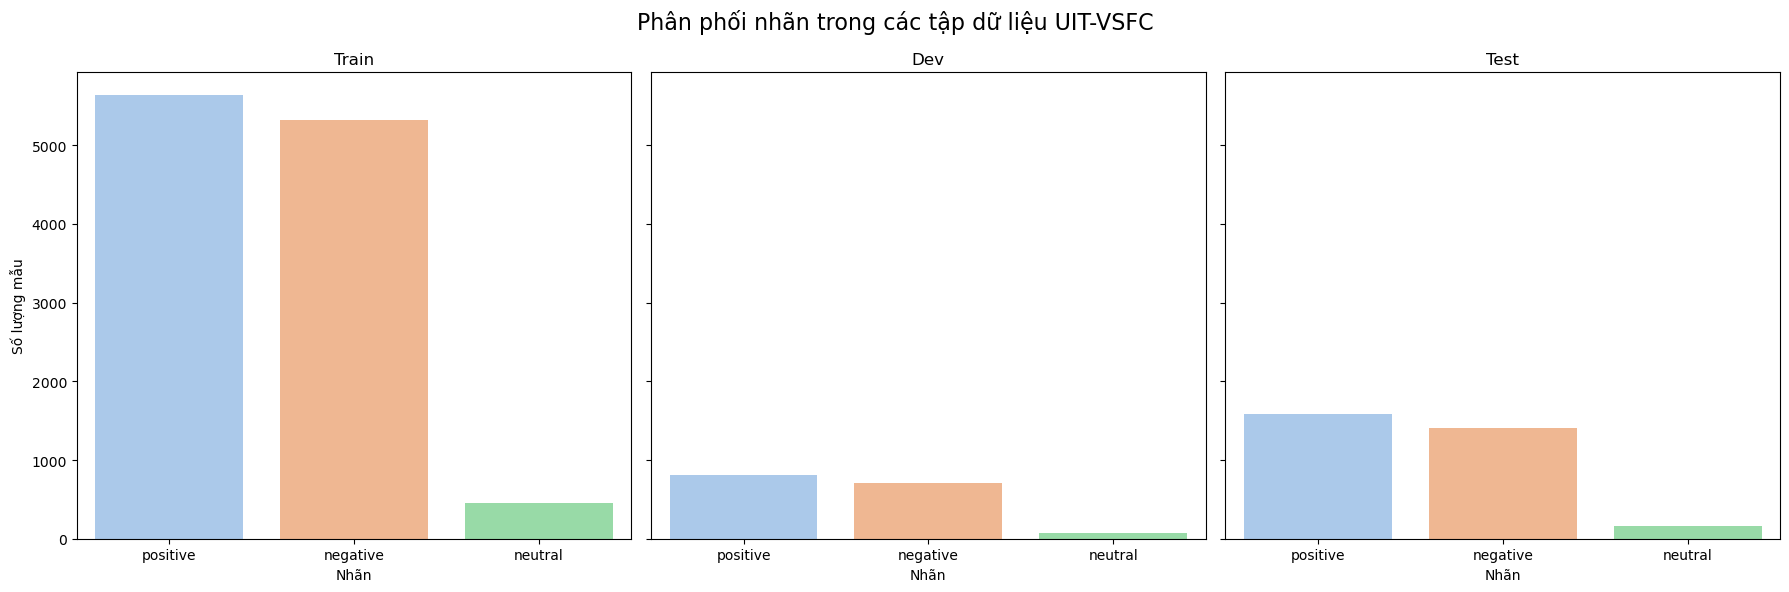

In [8]:
# Vẽ biểu đồ (bar chart) phân bố nhãn.
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.countplot(x='sentiment', data=UIT_VSFC_train, ax=axes[0], palette='pastel', order=['positive', 'negative', 'neutral'])
axes[0].set_title('Train')
axes[0].set_xlabel('Nhãn')
axes[0].set_ylabel('Số lượng mẫu')

sns.countplot(x='sentiment', data=UIT_VSFC_dev, ax=axes[1], palette='pastel', order=['positive', 'negative', 'neutral'])
axes[1].set_title('Dev')
axes[1].set_xlabel('Nhãn')
axes[1].set_ylabel('')

sns.countplot(x='sentiment', data=UIT_VSFC_test, ax=axes[2], palette='pastel', order=['positive', 'negative', 'neutral'])
axes[2].set_title('Test')
axes[2].set_xlabel('Nhãn')
axes[2].set_ylabel('')

plt.suptitle('Phân phối nhãn trong các tập dữ liệu UIT-VSFC', fontsize=16)
plt.tight_layout()
plt.show()


In [9]:
# Hàm tính % nhãn neutral
def neutral_ratio(df, name="Dataset"):
    total = len(df)
    neutral_count = (df['sentiment'] == 'neutral').sum()
    ratio = neutral_count / total * 100
    print(f"Tỉ lệ neutral trong {name}: {ratio:.2f}%")

# Áp dụng cho từng bộ dữ liệu
neutral_ratio(UIT_VSFC_train, "Train")
neutral_ratio(UIT_VSFC_dev, "Dev")
neutral_ratio(UIT_VSFC_test, "Test")

Tỉ lệ neutral trong Train: 4.01%
Tỉ lệ neutral trong Dev: 4.61%
Tỉ lệ neutral trong Test: 5.27%


Bộ dữ liệu có dấu hiệu mất cân bằng nhãn: Nhãn neutral chiếm tỉ lệ rất thấp trong 3 tập dữ liệu (dưới 6%), đặc biệt ở tập Train thì nhãn neutral chỉ chiếm 4.01%.  
Điều này có thể dẫn đến mất cân bằng lớp khi huấn luyện mô hình. Mô hình có thể thiên vị các nhãn phổ biến hơn (positive và negative) và bỏ qua nhãn ít phổ biến (neutral).

3. Phân tích độ dài câu

* Tính số token/word trong từng câu.

* Vẽ histogram hoặc boxplot độ dài câu.

Tìm: Max sequence length hợp lý khi padding (ví dụ: 50, 100, 200).

In [10]:
# Tính số token/word trong từng câu.
UIT_VSFC_train['word_count'] = UIT_VSFC_train['sentence'].apply(lambda x: len(x.split()))
UIT_VSFC_dev['word_count'] = UIT_VSFC_dev['sentence'].apply(lambda x: len(x.split()))
UIT_VSFC_test['word_count'] = UIT_VSFC_test['sentence'].apply(lambda x: len(x.split()))

# Thống kê độ dài câu.
print('Thống kê độ dài câu trong tập Train:\n', UIT_VSFC_train['word_count'].describe())
print('Thống kê độ dài câu trong tập Dev:\n', UIT_VSFC_dev['word_count'].describe())
print('Thống kê độ dài câu trong tập Test:\n', UIT_VSFC_test['word_count'].describe())

Thống kê độ dài câu trong tập Train:
 count    11426.000000
mean        14.308769
std         10.089727
min          2.000000
25%          8.000000
50%         11.000000
75%         17.000000
max        159.000000
Name: word_count, dtype: float64
Thống kê độ dài câu trong tập Dev:
 count    1583.000000
mean       13.671510
std         9.912805
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max       161.000000
Name: word_count, dtype: float64
Thống kê độ dài câu trong tập Test:
 count    3166.000000
mean       14.220783
std        10.242381
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        98.000000
Name: word_count, dtype: float64


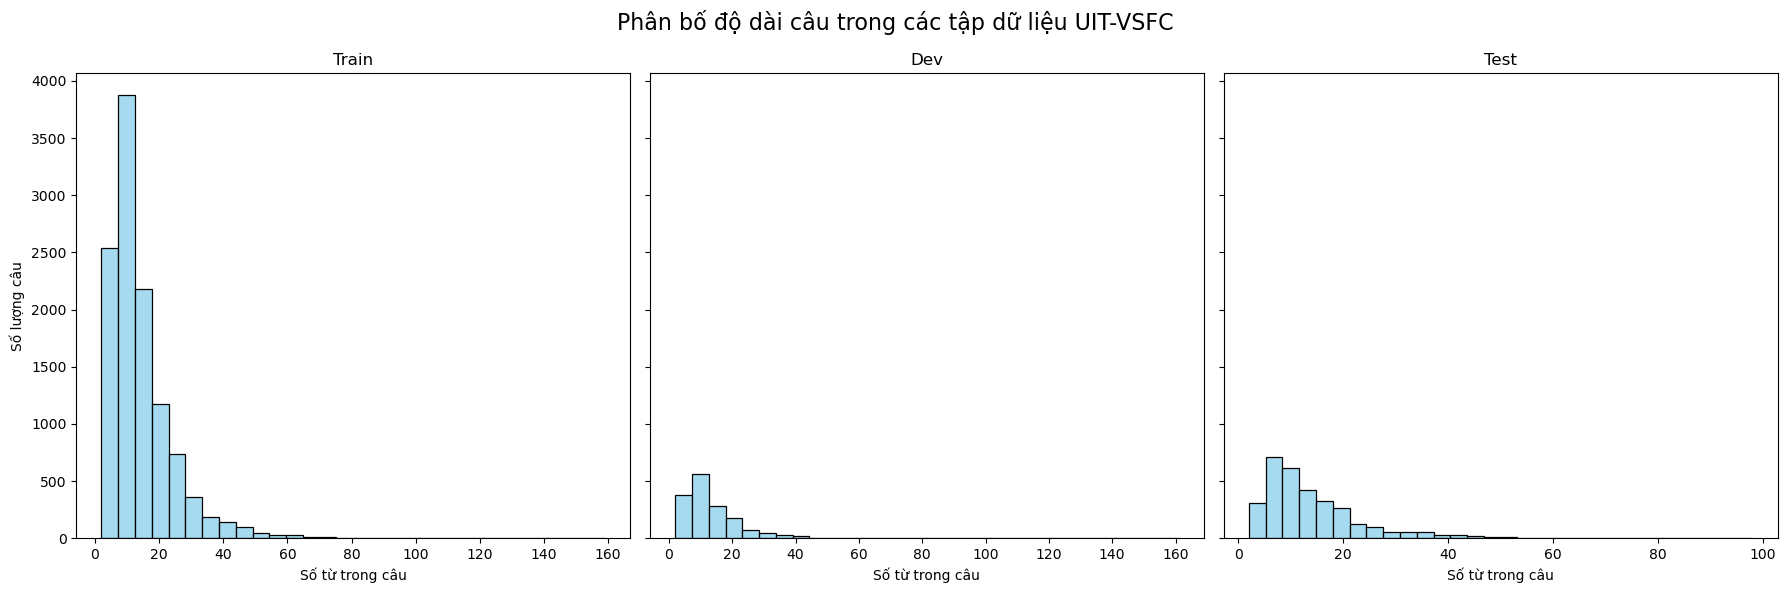

In [11]:
# Vẽ biểu đồ phân bố độ dài câu.
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(UIT_VSFC_train['word_count'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Train')
axes[0].set_xlabel('Số từ trong câu')
axes[0].set_ylabel('Số lượng câu')

sns.histplot(UIT_VSFC_dev['word_count'], bins=30, ax=axes[1], color='skyblue')
axes[1].set_title('Dev')
axes[1].set_xlabel('Số từ trong câu')
axes[1].set_ylabel('')

sns.histplot(UIT_VSFC_test['word_count'], bins=30, ax=axes[2], color='skyblue')
axes[2].set_title('Test')
axes[2].set_xlabel('Số từ trong câu')
axes[2].set_ylabel('')

plt.suptitle('Phân bố độ dài câu trong các tập dữ liệu UIT-VSFC', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
def ratio_under_threshold(df, threshold, name="Dataset"):
    total = len(df)
    count = (df['word_count'] <= threshold).sum()
    ratio = count / total * 100
    print(f"Tỉ lệ câu <= {threshold} từ trong {name}: {ratio:.2f}%")

# Áp dụng cho từng ngưỡng và từng tập
for threshold in [50, 100, 200]:
    ratio_under_threshold(UIT_VSFC_train, threshold, "Train")
    ratio_under_threshold(UIT_VSFC_dev, threshold, "Dev")
    ratio_under_threshold(UIT_VSFC_test, threshold, "Test")

Tỉ lệ câu <= 50 từ trong Train: 98.86%
Tỉ lệ câu <= 50 từ trong Dev: 99.18%
Tỉ lệ câu <= 50 từ trong Test: 98.83%
Tỉ lệ câu <= 100 từ trong Train: 99.96%
Tỉ lệ câu <= 100 từ trong Dev: 99.94%
Tỉ lệ câu <= 100 từ trong Test: 100.00%
Tỉ lệ câu <= 200 từ trong Train: 100.00%
Tỉ lệ câu <= 200 từ trong Dev: 100.00%
Tỉ lệ câu <= 200 từ trong Test: 100.00%


Chọn max sequence length = 50 vì:
- Bao phủ khoảng 99% dữ liệu ở cả ba tập Train/Dev/Test.
- Giúp tiết kiệm tài nguyên tính toán và bộ nhớ, tăng tốc độ huấn luyện.
- Giảm số lượng token PAD, giúp mô hình tập trung vào nội dung thực thay vì nhiễu.
- Chỉ cắt bỏ <2% dữ liệu, mức mất mát này rất nhỏ so với lợi ích đạt được.

4. Thống kê từ vựng

* Đếm số lượng từ vựng (unique tokens).

* Top 20 từ xuất hiện nhiều nhất.

* Trả lời câu hỏi: Có cần làm preprocessing không? (lowercase, remove punctuation, fix unicode…)

In [13]:
# Đếm số lượng từ vựng (unique tokens)
def unique_tokens(df):
    all_text = ' '.join(df['sentence'])
    tokens = set(all_text.split())
    return len(tokens)

print('Số lượng từ vựng trong tập Train:', unique_tokens(UIT_VSFC_train))
print('Số lượng từ vựng trong tập Dev:', unique_tokens(UIT_VSFC_dev))
print('Số lượng từ vựng trong tập Test:', unique_tokens(UIT_VSFC_test))

Số lượng từ vựng trong tập Train: 2514
Số lượng từ vựng trong tập Dev: 1157
Số lượng từ vựng trong tập Test: 1581


In [14]:
# Top 20 từ xuất hiện nhiều nhất.
def top_n_words(df, n=20):
    all_text = ' '.join(df['sentence'])
    tokens = all_text.split()
    counter = Counter(tokens)
    return counter.most_common(n)

print('Top 20 từ trong tập Train:', top_n_words(UIT_VSFC_train, 20))
print('Top 20 từ trong tập Dev:', top_n_words(UIT_VSFC_dev, 20))
print('Top 20 từ trong tập Test:', top_n_words(UIT_VSFC_test, 20))

Top 20 từ trong tập Train: [('.', 11009), (',', 6827), ('viên', 4803), ('giảng', 3711), ('dạy', 3156), ('thầy', 3095), ('sinh', 3082), ('học', 2940), ('bài', 2336), ('tình', 2266), ('không', 2177), ('và', 2068), ('có', 2031), ('rất', 1961), ('nhiệt', 1931), ('cho', 1735), ('hiểu', 1730), ('nhiều', 1622), ('tập', 1454), ('dễ', 1438)]
Top 20 từ trong tập Dev: [('.', 1528), (',', 948), ('viên', 644), ('giảng', 543), ('dạy', 459), ('thầy', 415), ('sinh', 400), ('học', 366), ('bài', 328), ('tình', 321), ('nhiệt', 282), ('rất', 280), ('không', 271), ('và', 270), ('có', 257), ('hiểu', 238), ('cho', 238), ('nhiều', 235), ('thực', 206), ('dễ', 199)]
Top 20 từ trong tập Test: [('.', 3064), (',', 1890), ('viên', 1253), ('giảng', 985), ('dạy', 908), ('thầy', 899), ('học', 808), ('sinh', 796), ('không', 648), ('bài', 645), ('tình', 624), ('và', 566), ('rất', 560), ('nhiệt', 548), ('có', 516), ('hiểu', 459), ('cho', 443), ('nhiều', 426), ('dễ', 403), ('tập', 391)]


Cần tiền xử lí vì:
- Dấu . và dấu , đang chiếm vị trí top đầu dù hai dấu này không có ý nghĩa gì cho bài toán phân loại cảm xúc.  
- Các từ như "viên", "giảng", "dạy" có thể là thuộc cụm từ "giảng viên giảng dạy" hay "giảng viên dạy học" đang bị tách ra.  
- Các từ như "và", "có", "cho" thường không mang ý nghĩa phân loại đặc biệt.  

5. Tiền xử lý dữ liệu

* Sinh viên phải mô tả:

* Các bước preprocessing sẽ áp dụng cho text: chuẩn hóa unicode, tách từ (tokenization dùng VnCoreNLP / underthesea / pyvi…), lowercasing, xử lý emoji, loại bỏ ký tự thừa, ...

Minh hoạ bằng ví dụ before → after.

In [15]:
def preprocess_text(text):
    # In ra trước khi xử lý
    print("Before:", text)
    
    # Chuẩn hóa chữ thường
    text = text.lower()
    
    # Loại bỏ dấu câu và ký tự đặc biệt
    text = re.sub(r'[^\w\s]', '', text)
    
    # Chuẩn hóa mã Unicode
    text = unicodedata.normalize('NFKC', text)
    
    # Tách từ dính liền
    text = re.sub(r'([a-zA-Z])([0-9])', r'\1 \2', text)
    
    # Chuẩn hóa khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tách từ bằng underthesea
    text = underthesea.word_tokenize(text, format="text")
    
    # In ra sau khi xử lý
    print("After:", text)
    
    return text
    

In [16]:
# Áp dụng tiền xử lý
UIT_VSFC_train['cleaned_sentence'] = UIT_VSFC_train['sentence'].apply(preprocess_text)
UIT_VSFC_dev['cleaned_sentence'] = UIT_VSFC_dev['sentence'].apply(preprocess_text)
UIT_VSFC_test['cleaned_sentence'] = UIT_VSFC_test['sentence'].apply(preprocess_text)

Before: slide giáo trình đầy đủ .
After: slide giáo_trình đầy_đủ
Before: nhiệt tình giảng dạy , gần gũi với sinh viên .
After: nhiệt_tình giảng_dạy gần_gũi với sinh_viên
Before: đi học đầy đủ full điểm chuyên cần .
After: đi học đầy_đủ full_điểm chuyên cần
Before: chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy .
After: chưa áp_dụng công_nghệ_thông_tin và các thiết_bị hỗ_trợ cho việc giảng_dạy
Before: thầy giảng bài hay , có nhiều bài tập ví dụ ngay trên lớp .
After: thầy giảng bài hay có nhiều bài_tập ví_dụ ngay trên lớp
Before: giảng viên đảm bảo thời gian lên lớp , tích cực trả lời câu hỏi của sinh viên , thường xuyên đặt câu hỏi cho sinh viên .
After: giảng_viên đảm_bảo thời_gian lên lớp tích_cực trả_lời câu hỏi của sinh_viên thường_xuyên đặt câu hỏi cho sinh_viên
Before: em sẽ nợ môn này , nhưng em sẽ học lại ở các học kỳ kế tiếp .
After: em sẽ nợ môn này nhưng em sẽ học lại ở các học_kỳ kế_tiếp
Before: thời lượng học quá dài , không đảm bảo tiếp thu hiệ

## BỘ DỮ LIỆU PhoNERT

1. Kiểm tra cấu trúc dữ liệu

* Tải và đọc các file train, test, dev.

* In 20 dòng đầu để xem cấu trúc dữ liệu BIO

In [17]:
# Tải và đọc các file train, test, dev.
PhoNERT_train = pd.read_json('PhoNERT/word/train_word.json', encoding = 'utf-8', lines=True)
PhoNERT_dev = pd.read_json('PhoNERT/word/dev_word.json', encoding = 'utf-8', lines=True)
PhoNERT_test = pd.read_json('PhoNERT/word/test_word.json', encoding = 'utf-8', lines=True)

In [18]:
# In 20 dòng đầu để xem cấu trúc dữ liệu BIO
print('20 dòng đầu trong tập Train PhoNERT:')
print(PhoNERT_train.head(20))

print('\n20 dòng đầu trong tập Dev PhoNERT:')
print(PhoNERT_dev.head(20))

print('\n20 dòng đầu trong tập Test PhoNERT:')
print(PhoNERT_test.head(20))

20 dòng đầu trong tập Train PhoNERT:
                                                words  \
0   [Đồng_thời, ,, bệnh_viện, tiếp_tục, thực_hiện,...   
1   [", Số, bệnh_viện, có_thể, tiếp_nhận, bệnh_nhâ...   
2   [Ngoài_ra, ,, những, người, tiếp_xúc, gián_tiế...   
3   [Bà, này, khi, trở, về, quá_cảnh, Doha, (, Qat...   
4   [", Bệnh_nhân, 523, ", và, chồng, là, ", bệnh_...   
5   [Trường_hợp, bệnh_nhân, 188, L.T.H., ,, theo, ...   
6   [Riêng, bệnh_nhân, 91, là, phi_công, người, An...   
7   [Bệnh_nhân, đã, được, xét_nghiệm, có, 3, kết_q...   
8   [Bà, đã, tiếp_xúc, với, người_thân, xác_định, ...   
9   [Chiều, 22, -, 4, ,, bệnh_nhân, được, cho, về,...   
10  [Hôm_qua, ,, hai, bệnh_nhân, Covid, -, 19, cũn...   
11  [8h, ngày, 1, -, 8, ,, bệnh_nhân, 861, chở, co...   
12  [Cả, hai, đều, thuộc, diện, xét_nghiệm, sàng_l...   
13  [Tính, đến, ngày, 11, -, 3, ,, trên, địa_bàn, ...   
14  [Sở, GD, -, ĐT, đã, quán_triệt, tất_cả, thí_si...   
15  [Những, người, vào, trung_tâm, cách_ly, được, .

2. Thống kê số câu trong từng tập

* Số câu trong train/dev/test

* Số lượng token mỗi tập

In [19]:
# Số câu trong train/dev/test
print('Số câu trong tập Train PhoNERT:', len(PhoNERT_train))
print('Số câu trong tập Dev PhoNERT:', len(PhoNERT_dev))
print('Số câu trong tập Test PhoNERT:', len(PhoNERT_test))

Số câu trong tập Train PhoNERT: 5027
Số câu trong tập Dev PhoNERT: 2000
Số câu trong tập Test PhoNERT: 3000


In [20]:
# Số lượng token mỗi tập
print('Số lượng token trong tập Train PhoNERT:', PhoNERT_train['words'].apply(len).sum())
print('Số lượng token trong tập Dev PhoNERT:', PhoNERT_dev['words'].apply(len).sum())
print('Số lượng token trong tập Test PhoNERT:', PhoNERT_test['words'].apply(len).sum())

Số lượng token trong tập Train PhoNERT: 132511
Số lượng token trong tập Dev PhoNERT: 56283
Số lượng token trong tập Test PhoNERT: 85678


3. Phân bố nhãn thực thể

* Thống kê số lần xuất hiện của từng nhãn (B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, O,...).

* Vẽ biểu đồ bar chart phân bố nhãn.

Trả lời:

* Nhãn nào xuất hiện nhiều nhất?

* Nhãn nào xuất hiện hiếm?

In [21]:
# Thống kê số lần xuất hiện của từng nhãn (B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, O,...).
train_counts = PhoNERT_train['tags'].explode().value_counts().sort_values()
dev_counts = PhoNERT_dev['tags'].explode().value_counts().sort_values()
test_counts = PhoNERT_test['tags'].explode().value_counts().sort_values()

tong_counts = train_counts.add(dev_counts, fill_value=0).add(test_counts, fill_value=0)

print("Phân phối nhãn trong tập Train PhoNERT:\n", train_counts)
print("Phân phối nhãn trong tập Dev PhoNERT:\n", dev_counts)
print("Phân phối nhãn trong tập Test PhoNERT:\n", test_counts)
print("Tổng cộng các nhãn trong cả ba tập:\n", tong_counts)


Phân phối nhãn trong tập Train PhoNERT:
 tags
I-AGE                         2
I-PATIENT_ID                 11
I-NAME                       13
I-JOB                        62
I-TRANSPORTATION             67
B-JOB                       205
B-TRANSPORTATION            226
B-NAME                      349
B-GENDER                    542
B-AGE                       682
B-ORGANIZATION             1137
B-SYMPTOM_AND_DISEASE      1439
I-SYMPTOM_AND_DISEASE      1552
I-DATE                     2500
I-ORGANIZATION             2545
B-DATE                     2549
B-PATIENT_ID               3240
I-LOCATION                 5242
B-LOCATION                 5398
O                        104750
Name: count, dtype: int64
Phân phối nhãn trong tập Dev PhoNERT:
 tags
I-NAME                       5
I-PATIENT_ID                 7
I-TRANSPORTATION            25
I-JOB                       49
B-TRANSPORTATION            87
B-JOB                      132
B-NAME                     188
B-GENDER                   

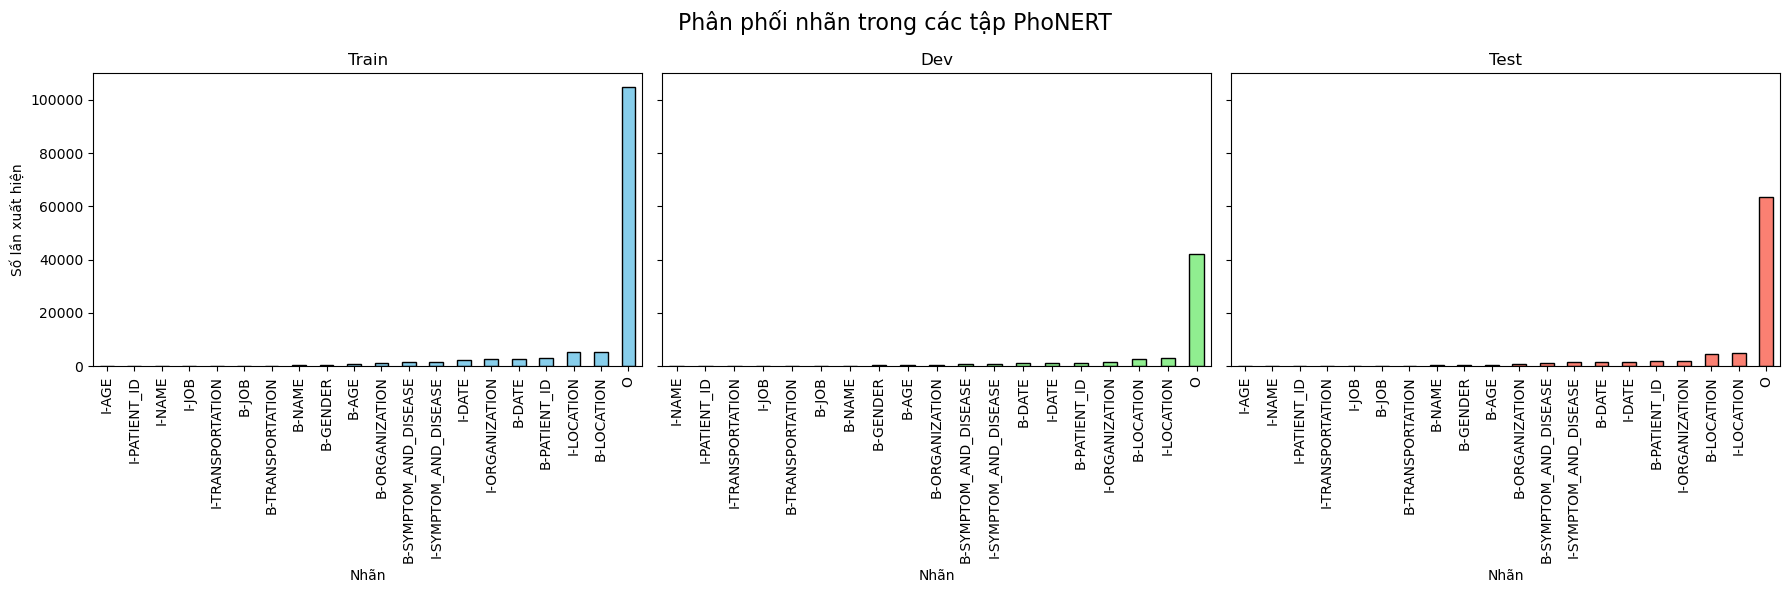

In [22]:
# Vẽ biểu đồ phân phối nhãn cho các tập
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

train_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title("Train")
axes[0].set_xlabel("Nhãn")
axes[0].set_ylabel("Số lần xuất hiện")
axes[0].tick_params(axis='x', rotation=90)

dev_counts.plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title("Dev")
axes[1].set_xlabel("Nhãn")
axes[1].tick_params(axis='x', rotation=90)

test_counts.plot(kind='bar', ax=axes[2], color='salmon', edgecolor='black')
axes[2].set_title("Test")
axes[2].set_xlabel("Nhãn")
axes[2].tick_params(axis='x', rotation=90)

plt.suptitle("Phân phối nhãn trong các tập PhoNERT", fontsize=16)
plt.tight_layout()
plt.show()


- Ở cả ba tập train, dev và test thì nhãn xuất hiện nhiều nhất là O (lần lượt là 104750, 42166, 63546).  
- Ở tập train, nhãn ít nhất là I-AGE với 2.
- Ở tập dev, nhãn ít nhất là I-NAME với 5.  
- Ở tập test, nhãn ít nhất là I-AGE với 6

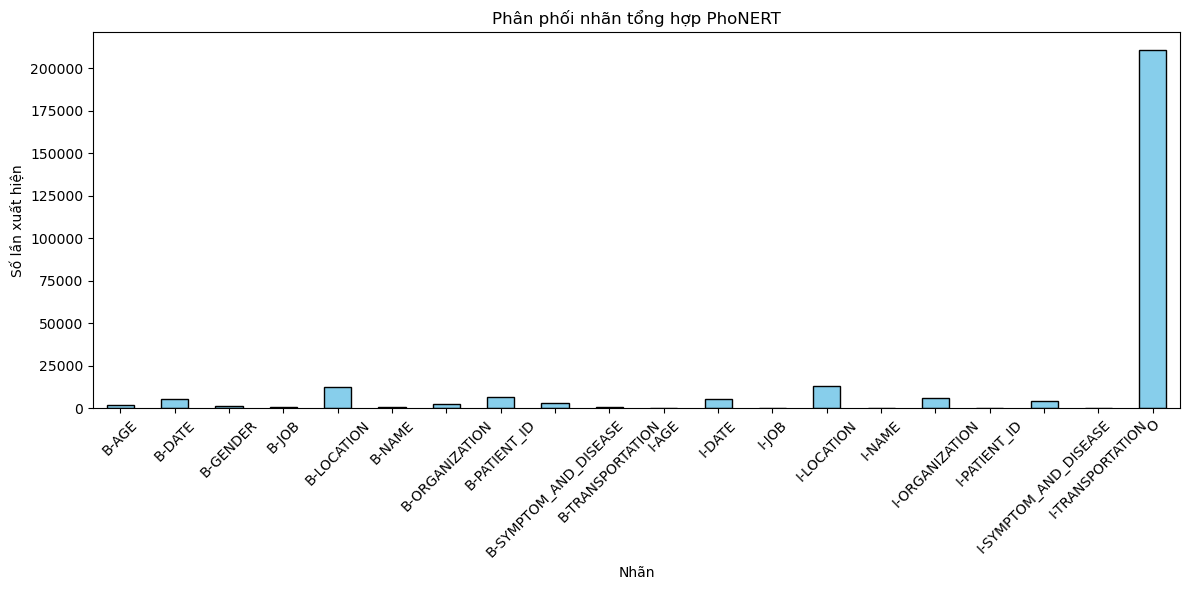

In [23]:
# Vẽ biểu đồ bar chart phân bố nhãn.
plt.figure(figsize=(12,6))
tong_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Phân phối nhãn tổng hợp PhoNERT")
plt.xlabel("Nhãn")
plt.ylabel("Số lần xuất hiện")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ở cả ba tập, nhãn ít nhất là B-AGE với 1625 và nhiều nhất là O với 210462

4. Phân tích độ dài câu

* Tính số token cho từng câu.

* Tìm min / max / mean.

Trả lời câu hỏi: padding tối ưu? có câu nào quá dài gây bất lợi cho LSTM?

In [24]:
# Tính số token cho từng câu và tìm min/max/mean
print('Số lượng token trong từng câu của tập Train PhoNERT:\n', PhoNERT_train['words'].apply(len).describe())
print('Số lượng token trong từng câu của tập Dev PhoNERT:\n', PhoNERT_dev['words'].apply(len).describe())
print('Số lượng token trong từng câu của tập Test PhoNERT:\n', PhoNERT_test['words'].apply(len).describe())

Số lượng token trong từng câu của tập Train PhoNERT:
 count    5027.000000
mean       26.359857
std        12.504579
min         6.000000
25%        18.000000
50%        24.000000
75%        32.000000
max       161.000000
Name: words, dtype: float64
Số lượng token trong từng câu của tập Dev PhoNERT:
 count    2000.000000
mean       28.141500
std        13.466297
min         7.000000
25%        19.000000
50%        25.000000
75%        34.000000
max       138.000000
Name: words, dtype: float64
Số lượng token trong từng câu của tập Test PhoNERT:
 count    3000.000000
mean       28.559333
std        13.881500
min         7.000000
25%        19.000000
50%        26.000000
75%        35.000000
max       162.000000
Name: words, dtype: float64


Phần lớn các câu có trung bình khoảng 20 - 35 token nhưng vẫn có một số câu rất dài 138 - 162 token. Điều này tạo độ khó cho LSTM vì mô hình này khó học ngữ cảnh xa và nguy cơ gradient vanishing.

In [25]:
# Tìm Padding tối ưu
def choose_padding_threshold(df, thresholds=[50, 100, 200], name="PhoNERT"):
    # Tính số token cho từng câu
    df['word_count'] = df['words'].apply(len)
    total = len(df)

    # Tỉ lệ câu dưới các ngưỡng
    for threshold in thresholds:
        count = (df['word_count'] <= threshold).sum()
        ratio = count / total * 100
        print(f"Tỉ lệ câu <= {threshold} từ trong {name}: {ratio:.2f}%")
        
choose_padding_threshold(PhoNERT_train, name="Train PhoNERT")
choose_padding_threshold(PhoNERT_dev, name="Dev PhoNERT")
choose_padding_threshold(PhoNERT_test, name="Test PhoNERT")

Tỉ lệ câu <= 50 từ trong Train PhoNERT: 95.13%
Tỉ lệ câu <= 100 từ trong Train PhoNERT: 99.92%
Tỉ lệ câu <= 200 từ trong Train PhoNERT: 100.00%
Tỉ lệ câu <= 50 từ trong Dev PhoNERT: 93.50%
Tỉ lệ câu <= 100 từ trong Dev PhoNERT: 99.90%
Tỉ lệ câu <= 200 từ trong Dev PhoNERT: 100.00%
Tỉ lệ câu <= 50 từ trong Test PhoNERT: 92.97%
Tỉ lệ câu <= 100 từ trong Test PhoNERT: 99.77%
Tỉ lệ câu <= 200 từ trong Test PhoNERT: 100.00%


Chọn padding = 100 vì:  
- Bao phủ gần như 100% cả ba tập dữ liệu.  
- Giữ được khá đủ thông tin mà vẫn bảo đảm hiệu suất mô hình.  
- Tránh lãng phí như chọn 200 và cũng ít cắt bỏ dữ liệu hơn so với 50.  
-> Thế nên đây là lựa chọn cân bằng nhất giữa tốc độ huấn luyện và độ chính xác.

# BÀI TẬP

### Bài 1: Xây dựng mạng LSTM gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

In [26]:
X_train = UIT_VSFC_train['cleaned_sentence'].tolist()
y_train = UIT_VSFC_train['sentiment'].tolist()

X_dev = UIT_VSFC_dev['cleaned_sentence'].tolist()
y_dev = UIT_VSFC_dev['sentiment'].tolist()

X_test = UIT_VSFC_test['cleaned_sentence'].tolist()
y_test = UIT_VSFC_test['sentiment'].tolist()

In [27]:
# Ánh xạ token thành số
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

# Chuyển câu thành chuỗi số
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_dev_seq = tokenizer.texts_to_sequences(X_dev)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding để tất cả câu có cùng độ dài
maxlen = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_dev_pad = pad_sequences(X_dev_seq,   maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq,  maxlen=maxlen, padding='post')

In [28]:
# One-hot nhãn từ chuỗi
y_train_cat = pd.get_dummies(y_train).values
y_dev_cat = pd.get_dummies(y_dev).values
y_test_cat = pd.get_dummies(y_test).values

num_classes = y_train_cat.shape[1]

In [29]:
lstm = Sequential()
lstm.add(Input(shape=(maxlen,)))
lstm.add(Embedding(input_dim=20000, output_dim=300, input_length=maxlen))
for i in range(4):
    lstm.add(LSTM(256, return_sequences=True))
    lstm.add(Dropout(0.3))
lstm.add(LSTM(256))
lstm.add(Dropout(0.3))
lstm.add(Dense(num_classes, activation='softmax'))

c:\Anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 300)        │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 256)        │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,672,387 (33.08 MB)

 Trainable params: 8,672,387 (33.08 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Khởi tạo EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',    
    patience=3,             
    restore_best_weights=True 
)

In [33]:
his1 = lstm.fit(X_train_pad, y_train_cat, validation_data=(X_dev_pad, y_dev_cat), epochs=20, batch_size=64, callbacks=[early_stop])


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 966ms/step - accuracy: 0.7197 - loss: 0.6714 - val_accuracy: 0.8130 - val_loss: 0.5799
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 887ms/step - accuracy: 0.7710 - loss: 0.6163 - val_accuracy: 0.7025 - val_loss: 0.6776
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 871ms/step - accuracy: 0.7620 - loss: 0.6336 - val_accuracy: 0.7764 - val_loss: 0.6301
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 887ms/step - accuracy: 0.7896 - loss: 0.6044 - val_accuracy: 0.8307 - val_loss: 0.5143
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 907ms/step - accuracy: 0.7319 - loss: 0.6118 - val_accuracy: 0.5565 - val_loss: 0.7763
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 160s 896ms/step - accuracy: 0.8102 - loss: 0.5725 - val_accuracy: 0.8364 - val_loss: 0.5258
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 882ms/step - accuracy: 0.8545 - loss: 0.4627 - val_accuracy: 0.8787 - val_loss: 0.4193
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 879ms/step - accuracy: 0.8826 -

In [34]:
y_pred_lstm = lstm.predict(X_test_pad)
y_pred_lstm_classes = y_pred_lstm.argmax(axis=-1)
y_test_classes = y_test_cat.argmax(axis=-1)
print("LSTM Classification Report:\n", classification_report(y_test_classes, y_pred_lstm_classes, target_names=['negative', 'neutral', 'positive']))

99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.96      0.91      1409
     neutral       0.48      0.12      0.19       167
    positive       0.94      0.91      0.92      1590

    accuracy                           0.89      3166
   macro avg       0.76      0.66      0.67      3166
weighted avg       0.88      0.89      0.88      3166



In [35]:
print("F1 Score (macro) LSTM:", f1_score(y_test_classes, y_pred_lstm_classes, average='macro'))
print("F1 Score (weighted) LSTM:", f1_score(y_test_classes, y_pred_lstm_classes, average='weighted'))
print("F1 Score (micro) LSTM:", f1_score(y_test_classes, y_pred_lstm_classes, average='micro'))

F1 Score (macro) LSTM: 0.674277751474336
F1 Score (weighted) LSTM: 0.8779052387132616
F1 Score (micro) LSTM: 0.8919772583701832


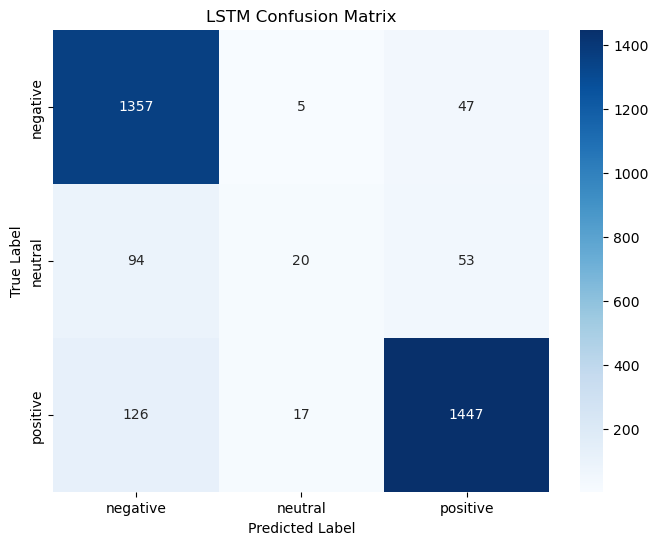

In [36]:
confusion_matrix_lstm = confusion_matrix(y_test_classes, y_pred_lstm_classes)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Bài 2: Xây dựng mạng GRU gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

In [37]:
gru = Sequential()
gru.add(Input(shape=(maxlen,)))
gru.add(Embedding(input_dim=20000, output_dim=300, input_length=maxlen))
for i in range(4):
    gru.add(GRU(256, return_sequences=True))
    gru.add(Dropout(0.3))
gru.add(GRU(256))
gru.add(Dropout(0.3))
gru.add(Dense(num_classes, activation='softmax'))

c:\Anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 300)        │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 256)        │       428,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,008,323 (30.55 MB)

 Trainable params: 8,008,323 (30.55 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Khởi tạo EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',    
    patience=3,             
    restore_best_weights=True 
)

In [41]:
his2 = gru.fit(X_train_pad, y_train_cat, validation_data=(X_dev_pad, y_dev_cat), epochs=20, batch_size=64, callbacks=[early_stop])

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 182s 977ms/step - accuracy: 0.4891 - loss: 0.8460 - val_accuracy: 0.5085 - val_loss: 0.8469
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 168s 941ms/step - accuracy: 0.4928 - loss: 0.8379 - val_accuracy: 0.6008 - val_loss: 0.8085
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 866ms/step - accuracy: 0.7149 - loss: 0.6158 - val_accuracy: 0.9021 - val_loss: 0.3171
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 161s 900ms/step - accuracy: 0.9043 - loss: 0.2970 - val_accuracy: 0.9166 - val_loss: 0.2665
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 164s 918ms/step - accuracy: 0.9268 - loss: 0.2350 - val_accuracy: 0.9147 - val_loss: 0.2558
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 907ms/step - accuracy: 0.9390 - loss: 0.1934 - val_accuracy: 0.9172 - val_loss: 0.2582
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9467 - loss: 0.1732 - val_accuracy: 0.9128 - val_loss: 0.2650
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9571 - loss:

In [42]:
y_pred_gru = gru.predict(X_test_pad)
y_pred_gru_classes = y_pred_gru.argmax(axis=-1)
print("GRU Classification Report:\n", classification_report(y_test_classes, y_pred_gru_classes, target_names=['negative', 'neutral', 'positive']))

99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step
GRU Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.95      0.92      1409
     neutral       0.55      0.37      0.44       167
    positive       0.94      0.93      0.93      1590

    accuracy                           0.91      3166
   macro avg       0.80      0.75      0.76      3166
weighted avg       0.90      0.91      0.90      3166



In [43]:
print("F1 Score (macro) GRU:", f1_score(y_test_classes, y_pred_gru_classes, average='macro'))
print("F1 Score (weighted) GRU:", f1_score(y_test_classes, y_pred_gru_classes, average='weighted'))
print("F1 Score (micro) GRU:", f1_score(y_test_classes, y_pred_gru_classes, average='micro'))

F1 Score (macro) GRU: 0.764169739267441
F1 Score (weighted) GRU: 0.9012955883728914
F1 Score (micro) GRU: 0.9055590650663298


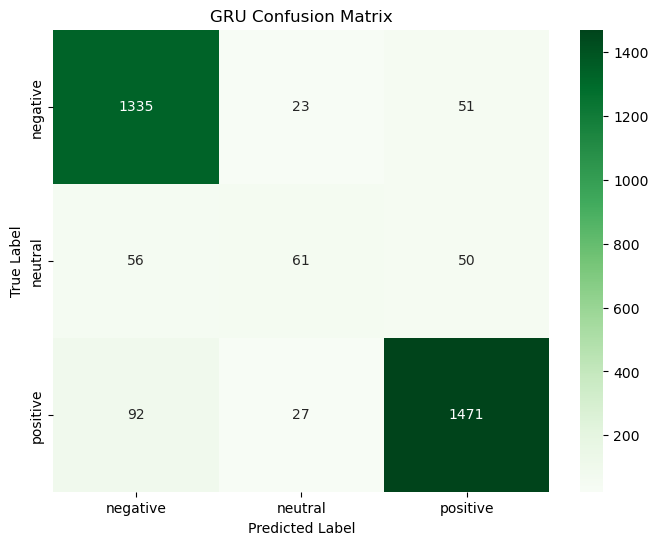

In [44]:
confusion_matrix_gru = confusion_matrix(y_test_classes, y_pred_gru_classes)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_gru, annot=True, fmt='d', cmap='Greens', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('GRU Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Bài 3: Xây dựng kiến trúc Encoder trong đó Encoder gồm 5 lớp BiLSTM với hidden size là 256 cho bài toán nhận diện thực thể (Name Entity Recognition). Huấn luyện mô hình trên bộ dữ liệu PhoNER và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

In [45]:
X_train = PhoNERT_train['words']
y_train = PhoNERT_train['tags']

X_dev = PhoNERT_dev['words']
y_dev = PhoNERT_dev['tags']

X_test = PhoNERT_test['words']
y_test = PhoNERT_test['tags']

In [50]:
# Làm sạch dữ liệu
def clean_dataset(dataset):
    cleaned = []
    for sent in dataset:
        if isinstance(sent, float) and math.isnan(sent):
            continue
        if not isinstance(sent, (list, tuple)):
            continue
        cleaned.append(sent)
    return cleaned

X_train = clean_dataset(X_train)
X_dev = clean_dataset(X_dev)
X_test = clean_dataset(X_test)
y_train = clean_dataset(y_train)
y_dev = clean_dataset(y_dev)
y_test = clean_dataset(y_test)

In [51]:
# Tạo từ điển word2id và tag2id
all_words = set([w for sent in X_train + X_dev + X_test for w in sent])
all_tags = set([t for sent in y_train + y_dev + y_test for t in sent])

word2id = {w: i + 2 for i, w in enumerate(sorted(all_words))}
word2id["PAD"] = 0
word2id["UNK"] = 1

tag2id = {t: i for i, t in enumerate(sorted(all_tags))}
tag2id["PAD"] = len(tag2id)  

# Hàm encode và padding
def encode_and_pad(sentences, labels, word2id, tag2id, max_len=100):
    X_ids, y_ids = [], []
    for words, tags in zip(sentences, labels):
        # encode
        word_ids = [word2id.get(w, word2id["UNK"]) for w in words]
        tag_ids = [tag2id[t] for t in tags]
        # padding
        word_ids = word_ids[:max_len] + [word2id["PAD"]] * (max_len - len(word_ids))
        tag_ids = tag_ids[:max_len] + [tag2id["PAD"]] * (max_len - len(tag_ids))
        X_ids.append(word_ids)
        y_ids.append(tag_ids)
    return np.array(X_ids), np.array(y_ids)

X_train_ids, y_train_ids = encode_and_pad(X_train, y_train, word2id, tag2id, max_len=100)
X_dev_ids, y_dev_ids = encode_and_pad(X_dev, y_dev, word2id, tag2id, max_len=100)
X_test_ids, y_test_ids = encode_and_pad(X_test, y_test, word2id, tag2id, max_len=100)


In [52]:
maxlen = 100
num_classes = len(tag2id)

# One-hot encode nhãn
y_train_onehot = tf.keras.utils.to_categorical(y_train_ids, num_classes=num_classes)
y_dev_onehot = tf.keras.utils.to_categorical(y_dev_ids, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_ids, num_classes=num_classes)

In [53]:
bilstm = Sequential()
bilstm.add(Input(shape=(maxlen,)))
bilstm.add(Embedding(input_dim=20000, output_dim=300, input_length=maxlen))
for i in range(5):
    bilstm.add(Bidirectional(LSTM(256, return_sequences=True)))
    bilstm.add(Dropout(0.3))
bilstm.add(TimeDistributed(Dense(num_classes, activation='softmax')))

c:\Anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
bilstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 512)       │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 21)        │        10,773 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,451,157 (51.31 MB)

 Trainable params: 13,451,157 (51.31 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
# Khởi tạo EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',    
    patience=3,             
    restore_best_weights=True 
)

In [57]:
his3 = bilstm.fit(X_train_ids, y_train_onehot, validation_data = (X_dev_ids, y_dev_onehot), epochs = 20, batch_size = 64, callbacks=[early_stop])

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 542s 7s/step - accuracy: 0.9195 - loss: 0.3746 - val_accuracy: 0.9294 - val_loss: 0.3139
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 593s 8s/step - accuracy: 0.9449 - loss: 0.2392 - val_accuracy: 0.9331 - val_loss: 0.2586
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 648s 8s/step - accuracy: 0.9527 - loss: 0.1706 - val_accuracy: 0.9533 - val_loss: 0.1639
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 664s 8s/step - accuracy: 0.9766 - loss: 0.0810 - val_accuracy: 0.9802 - val_loss: 0.0832
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 623s 8s/step - accuracy: 0.9896 - loss: 0.0378 - val_accuracy: 0.9841 - val_loss: 0.0671
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 630s 8s/step - accuracy: 0.9928 - loss: 0.0255 - val_accuracy: 0.9860 - val_loss: 0.0627
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 733s 9s/step - accuracy: 0.9946 - loss: 0.0191 - val_accuracy: 0.9861 - val_loss: 0.0624
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 787s 10s/step - accuracy: 0.9955 - loss: 0.0158 - val_accuracy: 0.9863 - 

In [68]:
y_pred_bilstm = bilstm.predict(X_test_ids)
y_pred_bilstm_classes = y_pred_bilstm.argmax(axis=-1)
y_test_classes = y_test_ids
print("BiLSTM Classification Report:\n", classification_report(y_test_classes.flatten(), y_pred_bilstm_classes.flatten(), target_names=list(tag2id.keys())))

94/94 ━━━━━━━━━━━━━━━━━━━━ 71s 757ms/step
BiLSTM Classification Report:
                        precision    recall  f1-score   support

                B-AGE       0.90      0.93      0.91       575
               B-DATE       0.96      0.95      0.95      1650
             B-GENDER       0.89      0.93      0.91       455
                B-JOB       0.30      0.46      0.36       173
           B-LOCATION       0.94      0.86      0.90      4435
               B-NAME       0.67      0.50      0.57       318
       B-ORGANIZATION       0.86      0.78      0.82       771
         B-PATIENT_ID       0.90      0.91      0.91      1988
B-SYMPTOM_AND_DISEASE       0.90      0.81      0.85      1136
     B-TRANSPORTATION       0.82      0.50      0.62       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.95      0.99      0.97      1740
                I-JOB       0.23      0.23      0.23       114
           I-LOCATION       0.95      0.82  

c:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [69]:
y_true = y_test_classes.argmax(axis=1)
y_pred = y_pred_bilstm_classes.argmax(axis=1)

print("F1 Score (macro) BILSTM:", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted) BILSTM:", f1_score(y_true, y_pred, average='weighted'))
print("F1 Score (micro) BILSTM:", f1_score(y_true, y_pred, average='micro'))

F1 Score (macro) BILSTM: 0.9714138675418574
F1 Score (weighted) BILSTM: 0.9990300389123743
F1 Score (micro) BILSTM: 0.9986666666666667


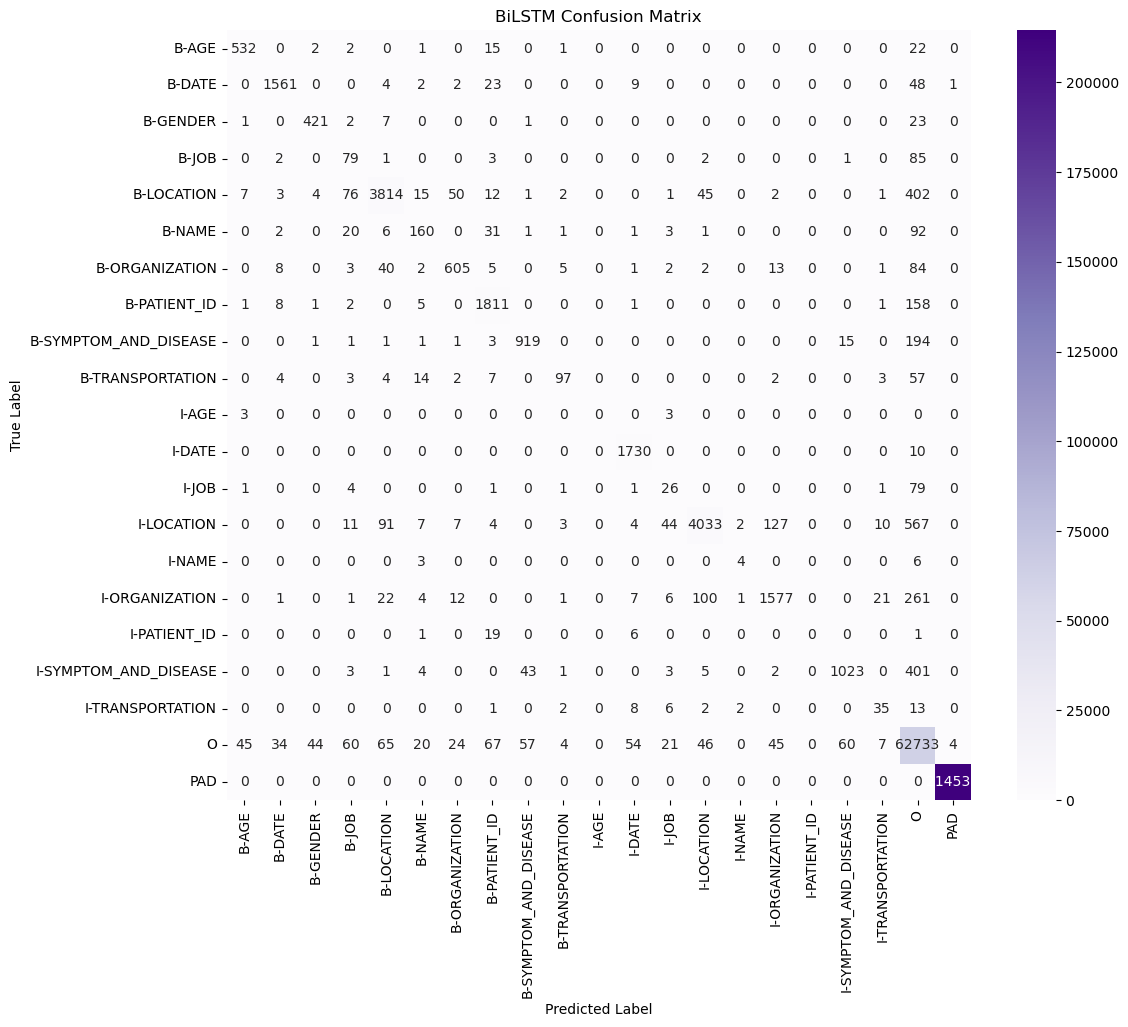

In [70]:
confusion_matrix_bilstm = confusion_matrix(y_test_classes.flatten(), y_pred_bilstm_classes.flatten())
plt.figure(figsize=(12,10)) 
sns.heatmap(confusion_matrix_bilstm, annot=True, fmt='d', cmap='Purples', xticklabels=list(tag2id.keys()), yticklabels=list(tag2id.keys()))
plt.title('BiLSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()